# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.1.0


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
print(train_stats)
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

               X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.764756  671.236156  319.218241  176.008958    5.267101    3.504886   
std      0.106418   88.358372   43.803157   45.354276    1.751343    1.102781   
min      0.620000  514.500000  245.000000  110.250000    3.500000    2.000000   
25%      0.667500  594.125000  294.000000  122.500000    3.500000    3.000000   
50%      0.760000  661.500000  318.500000  147.000000    7.000000    3.000000   
75%      0.850000  753.375000  343.000000  220.500000    7.000000    4.000000   
max      0.980000  808.500000  416.500000  220.500000    7.000000    5.000000   

               X7          X8          Y1          Y2  
count  614.000000  614.000000  614.000000  614.000000  
mean     0.234283    2.822476   22.439814   24.777296  
std      0.132985    1.545213   10.158602    9.640083  
min      0.000000    0.000000    6.010000   10

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [13]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units=128,activation=tf.nn.relu)(input_layer)
second_dense = Dense(units=128,activation=tf.nn.relu)(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          1152        input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          16512       dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 64)           8256        dense_6[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [16]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': tf.keras.losses.MeanSquaredError(), 'y2_output': tf.keras.losses.MeanSquaredError()},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [17]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 842us/sample - loss: 242.6584 - y1_output_loss: 113.3042 - y2_output_loss: 127.9704 - y1_output_root_mean_squared_error: 10.6773 - y2_output_root_mean_squared_error: 11.3426 - val_loss: 204.0689 - val_y1_output_loss: 46.1086 - val_y2_output_loss: 150.9568 - val_y1_output_root_mean_squared_error: 6.9002 - val_y2_output_root_mean_squared_error: 12.5082
Epoch 2/500
614/614 [==============================] - 0s 135us/sample - loss: 41.3236 - y1_output_loss: 14.5905 - y2_output_loss: 26.4192 - y1_output_root_mean_squared_error: 3.8367 - y2_output_root_mean_squared_error: 5.1578 - val_loss: 29.2119 - val_y1_output_loss: 9.3449 - val_y2_output_loss: 18.9933 - val_y1_output_root_mean_squared_error: 3.0919 - val_y2_output_root_mean_squared_error: 4.4330
Epoch 3/500
614/614 [==============================] - 0s 145us/sample - loss: 26.8232 - y1_output_loss: 10.3872 - y2_output_loss: 16.2398 - 

## Evaluate the Model and Plot Metrics

In [18]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 31us/sample - loss: 1.0309 - y1_output_loss: 0.1949 - y2_output_loss: 0.8476 - y1_output_root_mean_squared_error: 0.4294 - y2_output_root_mean_squared_error: 0.9201
Loss = 1.0309212950917033, Y1_loss = 0.19485369324684143, Y1_mse = 0.42938312888145447, Y2_loss = 0.8475981950759888, Y2_mse = 0.9200823307037354


In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 38us/sample - loss: 0.8272 - y1_output_loss: 0.1920 - y2_output_loss: 0.6387 - y1_output_root_mean_squared_error: 0.4355 - y2_output_root_mean_squared_error: 0.7985
Loss = 0.8272344624841368, Y1_loss = 0.1920401006937027, Y1_mse = 0.4355226457118988, Y2_loss = 0.6386582255363464, Y2_mse = 0.798470139503479


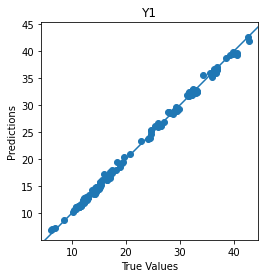

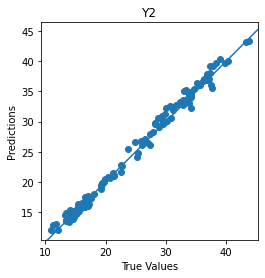

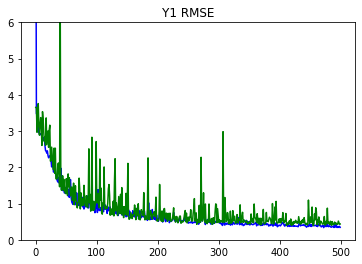

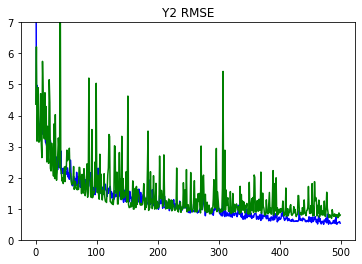

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)